In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
% matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten
from keras.layers import Activation, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers.normalization import BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np         
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm 

Using TensorFlow backend.


In [2]:
TRAIN_DIR='../input/train/'
TEST_DIR='../input/test/'
# IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match


In [3]:
def label_img(img):
    word_label = img.split('.')[0]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggy]
    elif word_label == 'dog': return [0,1]

In [4]:
def create_train_data():
    training_data = []
    for img in os.listdir(TRAIN_DIR):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        try:
            img = cv2.resize(img,(50,50), interpolation = cv2.INTER_CUBIC)
        except:
            print(img.size)
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [5]:
train_data = create_train_data()
# If you have already created the dataset:
# train_data = np.load('train_data.npy')


In [6]:
X=[]
Y=[]
for i in range(len(train_data)):
    X.append(train_data[i][0])
    Y.append(train_data[i][1])

X=np.array(X)
Y=np.array(Y) 


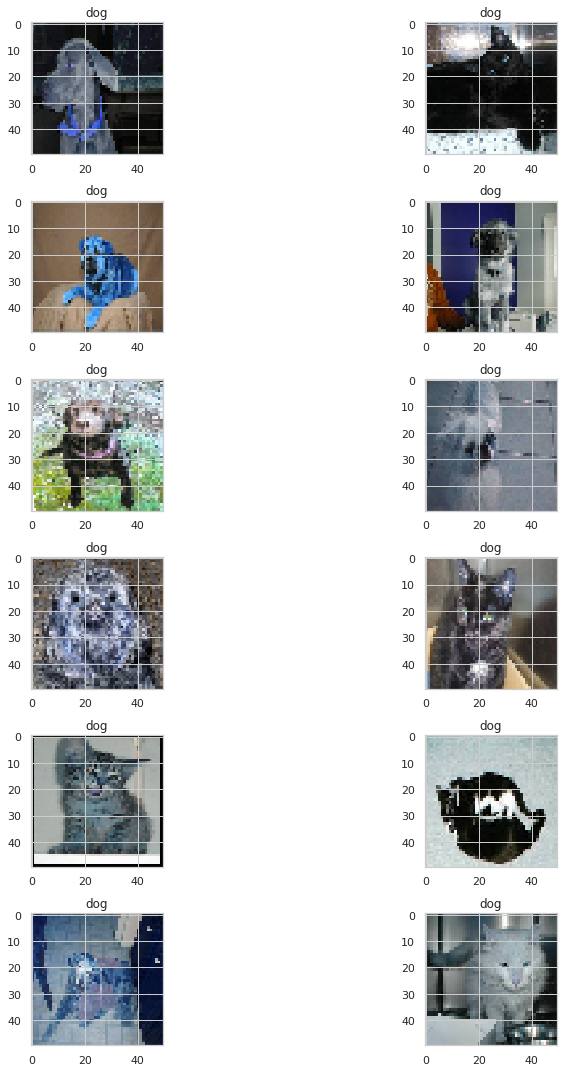

In [8]:
fig,ax=plt.subplots(6,2)
fig.set_size_inches(15,15)
for i in range(6):
    for j in range (2):
        l=rn.randint(0,len(Y))
        ax[i,j].imshow(X[l])
        def catordog():
            if X[l]==(1,0):
                return 'cat'
            else:
                return 'dog'
        ax[i,j].set_title(catordog())
        
plt.tight_layout()


In [9]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(20000, 50, 50, 3)
(5000, 50, 50, 3)
(20000, 2)
(5000, 2)


In [10]:
## Setting the seeds for Reproducibility.
seed = 66
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                 input_shape=(50,50,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        18496     
__________

In [16]:
# Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )
# Compiling the model
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [17]:
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
batch_size = 64
epochs = 15
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [19]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 15, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,callbacks=[reduce_lr])

Epoch 1/15
312/312 [==============================] - 33s 106ms/step - loss: 0.8297 - acc: 0.6284 - val_loss: 0.5895 - val_acc: 0.7036
Epoch 2/15
312/312 [==============================] - 27s 85ms/step - loss: 0.6012 - acc: 0.6962 - val_loss: 0.5637 - val_acc: 0.7292
Epoch 3/15
312/312 [==============================] - 27s 87ms/step - loss: 0.5345 - acc: 0.7374 - val_loss: 0.5204 - val_acc: 0.7548
Epoch 4/15
312/312 [==============================] - 26s 84ms/step - loss: 0.4950 - acc: 0.7595 - val_loss: 0.4640 - val_acc: 0.7854
Epoch 5/15
312/312 [==============================] - 27s 88ms/step - loss: 0.4624 - acc: 0.7808 - val_loss: 0.4722 - val_acc: 0.7782
Epoch 6/15
312/312 [==============================] - 28s 88ms/step - loss: 0.4386 - acc: 0.7933 - val_loss: 0.4467 - val_acc: 0.7920
Epoch 7/15
312/312 [==============================] - 27s 87ms/step - loss: 0.4151 - acc: 0.8101 - val_loss: 0.4508 - val_acc: 0.8114
Epoch 8/15
312/312 [==============================] - 26s 85m

In [22]:
model.evaluate(x_test, y_test)

5000/5000 [==============================] - 2s 336us/step


[0.38159228502511977, 0.8324]

Saving and Loading the model (save function will save Weight and all the parameters , optimizer , loss function, and the state where you left)

In [ ]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

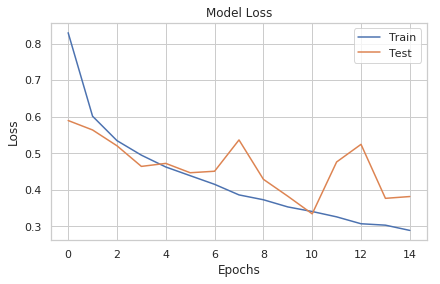

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

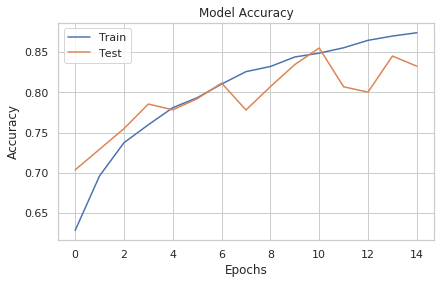

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.show()

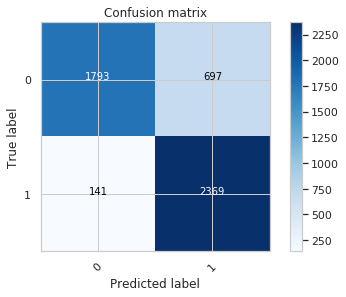

In [26]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [36]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (50,50))
        testing_data.append(np.array(img))
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data
test_data=process_test_data()

100%|██████████| 12500/12500 [00:30<00:00, 410.79it/s]


In [37]:
test_data = np.array(test_data)
test_data.shape

(12500, 50, 50, 3)

In [30]:
# test_data = test_data.astype("float32")/255

In [38]:
pred=model.predict(test_data)
print(pred)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [39]:
imageid=[]
pred_prob=[]
for i in range(len(test_data)):
    imageid.append(i+1)
    pred_prob.append(pred[i,1])
d={'id':imageid,'label':pred_prob}
ans=pd.DataFrame(d)
ans.to_csv('predictions.csv',index=False)

Saving and Loading the Model